In [1]:
import os
import numpy as np
import glob
import pandas as pd  
#from keras import utils as np_utils
import random
import math as mp
from scipy.signal import resample
from random import shuffle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
scaler = StandardScaler()

In [3]:
'''
# generate CHBMIT non seziure samples 
# chb-all
path='/home/ad930/datasetsv4/'
dr='non_seizures'
nfilenames=[]
end='/*.csv'
nfilenames=glob.glob(path + dr + end)
shuffle(nfilenames)

def generate_chbmit_datasets(filenames):
    counter=0
    oldFS=256
    newFS=173.61
    flag=0
    arry=[]    
    for files in filenames:
        if counter==1000:
            break
        df=pd.read_csv(files)
        if '\'F3-C3\'' in df:
            #df = df["'F3-C3'"]
            df = df[['\'F3-C3\'']]
            if df.shape[0] == 6041:
                newNumSamples = mp.ceil((df.shape[0] / oldFS) * newFS)
                flag=1
            if df.shape[0] == 6042:
                newNumSamples = mp.floor((df.shape[0] / oldFS) * newFS)
                flag=1
            if flag==1:
                newData = pd.DataFrame(resample(df, newNumSamples))
                arry.append(np.array(newData,dtype="float32"))
            counter=counter+1
    return np.array(arry) 
'''
path='/home/ad930/bonn_eeg_cnn/'
dr='Z'
nfilenames=[]
end='/*.txt'
nfilenames=glob.glob(path + dr + end)
import numpy as np
import pandas as pd

def generate_datasets(filenames):
    arry=[]    
    for files in filenames:
        df=pd.read_table(files,names="X")
        arry.append(np.array(df,dtype="float32"))
    return np.array(arry) 

In [4]:
chb_signals=generate_datasets(nfilenames)
chb_signals.shape

(100, 4097, 1)

In [5]:
X = chb_signals
XC=X
X1=X.reshape(len(X)*4097,order='F')
X2=X1.reshape(4097,len(X))

X2=scaler.fit_transform(X2)  #normalize(X2,axis=1)

X3=np.reshape(X2,4097*len(X),order='F')
X4=X3.reshape(len(X),4097,1)
X=X4
chb_signals = X

In [6]:
# load generator
from tensorflow.keras.models import load_model
gen = load_model('./GAN_Generator_model2.h5')

W0623 09:02:06.050083 140653782984448 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


In [7]:
# generate 500 synthetic seizure signals
signal_gen = []
for i in range(0,100):
    noise = tf.random.normal([1, 100])
    generated_signal = gen(noise, training=False)
    generated_signal = generated_signal[:,:,0,:]
    signal_gen.append(generated_signal[0])


In [8]:
signal_gen = np.array(signal_gen)

In [9]:
X = signal_gen
XC=X
X1=X.reshape(len(X)*4097,order='F')
X2=X1.reshape(4097,len(X))

X2=scaler.fit_transform(X2) #normalize(X2,axis=1)

X3=np.reshape(X2,4097*len(X),order='F')
X4=X3.reshape(len(X),4097,1)
X=X4
signal_gen = X

In [10]:
x_train = np.append(signal_gen,chb_signals, axis=0)  # 1,0
x_train.shape

(200, 4097, 1)

In [11]:
y_ones = np.ones((100,),dtype='int64')
y_zero = np.zeros((100,),dtype='int64')
y_train = np.append(y_ones, y_zero, axis=0)
y_train.shape

(200,)

In [12]:
xx_train, xx_test, yy_train, yy_test = train_test_split(x_train, y_train, test_size=0.20, random_state=42)

In [13]:
# Initialising the CNN
cnn = tf.keras.Sequential()

# First Convolution Layer
cnn.add(layers.Conv1D(4, 6, input_shape = (4097, 1), activation='relu'))
#cnn.add(layers.LeakyReLU(alpha=0.05))  
cnn.add(layers.BatchNormalization())
cnn.add(layers.MaxPooling1D(pool_size = 2, strides = 2))
#cnn.add(Dropout(0.25))

# Adding a second convolutional layer
cnn.add(layers.Conv1D(4, 5,activation='relu'))  #number of output filters, kernel size
#cnn.add(layers.LeakyReLU(alpha=0.05)) 
cnn.add(layers.MaxPooling1D(pool_size = 2, strides = 2))
#cnn.add(Dropout(0.25))

# Adding a third convolutional layer
cnn.add(layers.Conv1D(10, 4, activation='relu' ))
#cnn.add(layers.LeakyReLU(alpha=0.05)) 
cnn.add(layers.MaxPooling1D(pool_size = 2, strides = 2))
#cnn.add(Dropout(0.4))

# Adding a fourth convolutional layer
cnn.add(layers.Conv1D(10, 4, activation='relu' ))
#cnn.add(layers.LeakyReLU(alpha=0.05)) 
cnn.add(layers.MaxPooling1D(pool_size = 2, strides = 2))
#cnn.add(Dropout(0.4))

# Adding a fifth convolutional layer
cnn.add(layers.Conv1D(15, 4, activation='relu' ))
#cnn.add(layers.LeakyReLU(alpha=0.05)) 
cnn.add(layers.MaxPooling1D(pool_size = 2, strides = 2))
#cnn.add(Dropout(0.4))

# Step 3 - Flattening
cnn.add(layers.Flatten())

# Step 4 - Full connection
cnn.add(layers.Dense(units = 50, activation='relu'))
#cnn.add(layers.LeakyReLU(alpha=0.05)) 
#cnn.add(layers.Dropout(0.1))
cnn.add(layers.Dense(units = 20, activation='relu'))
#cnn.add(layers.LeakyReLU(alpha=0.05))
cnn.add(layers.Dense(units = 2, activation = 'softmax'))


# Compiling the CNN
cnn.compile(optimizer = tf.keras.optimizers.SGD(lr=0.01,momentum=0.3, decay=0.01), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [14]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 4092, 4)           28        
_________________________________________________________________
batch_normalization (BatchNo (None, 4092, 4)           16        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 2046, 4)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2042, 4)           84        
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 1021, 4)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1018, 10)          170       
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 509, 10)           0

In [15]:
model=cnn.fit(x=xx_train, y=yy_train, batch_size=5, epochs=100, verbose=1,validation_data=(xx_test,yy_test))

W0623 09:06:09.217583 140653782984448 deprecation.py:323] From /home/ad930/anaconda3/lib/python3.5/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 160 samples, validate on 40 samples
Epoch 1/100
160/160 [==============================] - 1s 5ms/sample - loss: 0.4813 - accuracy: 0.7750 - val_loss: 0.5474 - val_accuracy: 1.0000
Epoch 2/100
160/160 [==============================] - 0s 1ms/sample - loss: 0.1040 - accuracy: 1.0000 - val_loss: 0.3251 - val_accuracy: 1.0000
Epoch 3/100
160/160 [==============================] - 0s 1ms/sample - loss: 0.0181 - accuracy: 1.0000 - val_loss: 0.1997 - val_accuracy: 1.0000
Epoch 4/100
160/160 [==============================] - 0s 1ms/sample - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.1246 - val_accuracy: 1.0000
Epoch 5/100
160/160 [==============================] - 0s 1ms/sample - loss: 0.0051 - accuracy: 1.0000 - val_loss: 0.0772 - val_accuracy: 1.0000
Epoch 6/100
160/160 [==============================] - 0s 1ms/sample - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0467 - val_accuracy: 1.0000
Epoch 7/100
160/160 [==============================] - 0s 1ms/sample - loss: 0.0030 -

In [16]:
def plot_acc_valgraph(model,num):
    plt.figure(num)
    plt.plot(model.history['accuracy'])
    plt.plot(model.history['val_accuracy'])
    plt.legend(['Training','Validation'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')

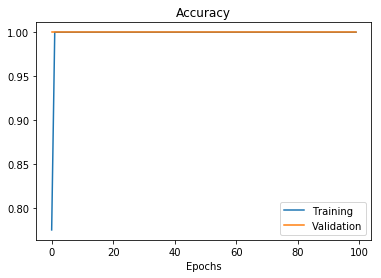

In [17]:
plot_acc_valgraph(model,1)

In [18]:
# evaluate the model
score = cnn.evaluate(xx_test, yy_test, verbose=0)
print('Test loss:', score[0]*100)
print('Test accuracy:', score[1]*100)

Test loss: 0.0343390874331817
Test accuracy: 100.0


In [19]:
yy_pred=cnn.predict(x=xx_test, verbose=1)

40/40 [==============================] - 0s 4ms/sample


In [20]:
yy_pred1 = np.argmax(yy_pred, axis=1)

In [21]:
accuracy = accuracy_score(yy_test, yy_pred1)
print(accuracy*100)

100.0


In [22]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    # '.2f' if normalize else 
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

[[19  0]
 [ 0 21]]


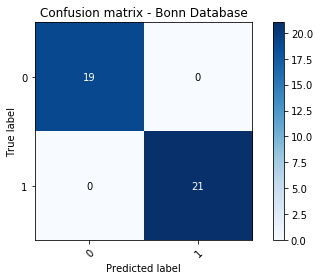

In [23]:
confusion_mat= plot_confusion_matrix(yy_test, yy_pred1, classes=[0,1], title='Confusion matrix - Bonn Database')

In [24]:
from sklearn.metrics import classification_report
print(classification_report(yy_test,yy_pred1,target_names = ['Non-Seizure(0)', 'Seizure(1)']))

                precision    recall  f1-score   support

Non-Seizure(0)       1.00      1.00      1.00        19
    Seizure(1)       1.00      1.00      1.00        21

      accuracy                           1.00        40
     macro avg       1.00      1.00      1.00        40
  weighted avg       1.00      1.00      1.00        40



In [26]:
# generate CHBMIT seziure samples 
path='/home/ad930/datasetsv4/'
dr='non_seizures'
nfilenames=[]
end='/*.csv'
nfilenames=glob.glob(path + dr + end)
shuffle(nfilenames)

def generate_chbmit_datasets(filenames):
    counter=0
    oldFS=256
    newFS=173.61
    flag=0
    arry=[]    
    for files in filenames:
        if counter == 169:
            break
        df=pd.read_csv(files)
        if '\'F3-C3\'' in df:
            #df = df["'F3-C3'"]
            df = df[['\'F3-C3\'']]
            if df.shape[0] == 6041:
                newNumSamples = mp.ceil((df.shape[0] / oldFS) * newFS)
                flag=1
            if df.shape[0] == 6042:
                newNumSamples = mp.floor((df.shape[0] / oldFS) * newFS)
                flag=1
            if flag==1:
                newData = pd.DataFrame(resample(df, newNumSamples))
                arry.append(np.array(newData,dtype="float32"))
            counter=counter+1
    return np.array(arry) 

In [27]:
chb_sez_signals_n1=generate_chbmit_datasets(nfilenames)
chb_sez_signals_n1.shape

(169, 4097, 1)

In [28]:
X = chb_sez_signals_n1
XC=X
X1=X.reshape(len(X)*4097,order='F')
X2=X1.reshape(4097,len(X))

X2=scaler.fit_transform(X2)    #normalize(X2,axis=1)

X3=np.reshape(X2,4097*len(X),order='F')
X4=X3.reshape(len(X),4097,1)
X=X4
chb_sez_signals_n1 = X

In [29]:
# generate CHBMIT seziure samples 
path='/home/ad930/datasetsv4/'
dr='seizures'
sfilenames=[]
end='/*.csv'
sfilenames=glob.glob(path + dr + end)


def generate_chbmit_datasets(filenames):
    counter=0
    oldFS=256
    newFS=173.61
    flag=0
    arry=[]    
    for files in filenames:
        df=pd.read_csv(files)
        if '\'F3-C3\'' in df:
            #df = df["'F3-C3'"]
            df = df[['\'F3-C3\'']]
            if df.shape[0] == 6041:
                newNumSamples = mp.ceil((df.shape[0] / oldFS) * newFS)
                flag=1
            if df.shape[0] == 6042:
                newNumSamples = mp.floor((df.shape[0] / oldFS) * newFS)
                flag=1
            if flag==1:
                newData = pd.DataFrame(resample(df, newNumSamples))
                arry.append(np.array(newData,dtype="float32"))
            counter=counter+1
    return np.array(arry) 

In [30]:
chb_sez_signals=generate_chbmit_datasets(sfilenames)
chb_sez_signals.shape

(169, 4097, 1)

In [31]:
X = chb_sez_signals
XC=X
X1=X.reshape(len(X)*4097,order='F')
X2=X1.reshape(4097,len(X))

X2=scaler.fit_transform(X2)    #normalize(X2,axis=1)

X3=np.reshape(X2,4097*len(X),order='F')
X4=X3.reshape(len(X),4097,1)
X=X4
chb_sez_signals = X

In [32]:
x_tst = np.append(chb_sez_signals,chb_sez_signals_n1, axis=0)  # 1,0
x_tst.shape

(338, 4097, 1)

In [33]:
y_ones = np.ones((169,),dtype='int64')
y_zero = np.zeros((169,),dtype='int64')
y_tst = np.append(y_ones, y_zero, axis=0)
y_tst.shape

(338,)

In [34]:
# evaluate the model
score = cnn.evaluate(x_tst, y_tst, verbose=0)
print('Test loss:', score[0]*100)
print('Test accuracy:', score[1]*100)

Test loss: 334.50156850065247
Test accuracy: 50.0


In [35]:
yy_pred=cnn.predict(x=x_tst, verbose=1)

338/338 [==============================] - 0s 300us/sample


In [36]:
yy_pred1 = np.argmax(yy_pred, axis=1)

In [37]:
accuracy = accuracy_score(y_tst, yy_pred1)
print(accuracy*100)

50.0


[[169   0]
 [169   0]]


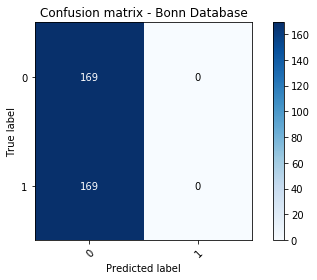

In [38]:
confusion_mat= plot_confusion_matrix(y_tst, yy_pred1, classes=[0,1], title='Confusion matrix - Bonn Database')

In [39]:
from sklearn.metrics import classification_report
print(classification_report(y_tst,yy_pred1,target_names = ['Non-Seizure(0)', 'Seizure(1)']))

                precision    recall  f1-score   support

Non-Seizure(0)       0.50      1.00      0.67       169
    Seizure(1)       0.00      0.00      0.00       169

      accuracy                           0.50       338
     macro avg       0.25      0.50      0.33       338
  weighted avg       0.25      0.50      0.33       338



/home/ad930/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [40]:
path='/home/ad930/bonn_eeg_cnn/'
dr='S'
sfilenames=[]
end='/*.txt'
sfilenames=glob.glob(path + dr + end)
import numpy as np
import pandas as pd

def generate_datasets(filenames):
    arry=[]    
    for files in filenames:
        df=pd.read_table(files,names="X")
        arry.append(np.array(df,dtype="float32"))
    return np.array(arry) 

In [41]:
signals = generate_datasets(sfilenames)
signals.shape

(100, 4097, 1)

In [42]:
X = signals
XC=X
X1=X.reshape(len(X)*4097,order='F')
X2=X1.reshape(4097,len(X))

X2=scaler.fit_transform(X2)  #normalize(X2,axis=1)

X3=np.reshape(X2,4097*len(X),order='F')
X4=X3.reshape(len(X),4097,1)
X=X4
signals = X

In [43]:
path='/home/ad930/bonn_eeg_cnn/'
dr='Z'
nfilenames=[]
end='/*.txt'
nfilenames=glob.glob(path + dr + end)
import numpy as np
import pandas as pd

def generate_datasets(filenames):
    arry=[]    
    for files in filenames:
        df=pd.read_table(files,names="X")
        arry.append(np.array(df,dtype="float32"))
    return np.array(arry) 

In [44]:
n_signals = generate_datasets(nfilenames)
n_signals.shape

(100, 4097, 1)

In [45]:
X = n_signals
XC=X
X1=X.reshape(len(X)*4097,order='F')
X2=X1.reshape(4097,len(X))

X2=scaler.fit_transform(X2)  #normalize(X2,axis=1)

X3=np.reshape(X2,4097*len(X),order='F')
X4=X3.reshape(len(X),4097,1)
X=X4
n_signals = X

In [46]:
x_tst = np.append(signals,n_signals, axis=0)  # 1,0
x_tst.shape

(200, 4097, 1)

In [47]:
y_ones = np.ones((100,),dtype='int64')
y_zero = np.zeros((100,),dtype='int64')
y_tst = np.append(y_ones, y_zero, axis=0)
y_tst.shape

(200,)

In [48]:
# evaluate the model
score = cnn.evaluate(x_tst, y_tst, verbose=0)
print('Test loss:', score[0]*100)
print('Test accuracy:', score[1]*100)

Test loss: 380.1202237275429
Test accuracy: 50.0


In [49]:
yy_pred=cnn.predict(x=x_tst, verbose=1)

200/200 [==============================] - 0s 83us/sample


In [50]:
yy_pred1 = np.argmax(yy_pred, axis=1)

In [51]:
accuracy = accuracy_score(y_tst, yy_pred1)
print(accuracy*100)

50.0


[[100   0]
 [100   0]]


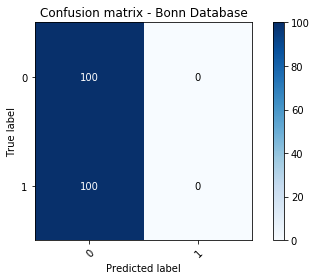

In [52]:
confusion_mat= plot_confusion_matrix(y_tst, yy_pred1, classes=[0,1], title='Confusion matrix - Bonn Database')

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_tst,yy_pred1,target_names = ['Non-Seizure(0)', 'Seizure(1)']))

                precision    recall  f1-score   support

Non-Seizure(0)       0.50      1.00      0.67       100
    Seizure(1)       0.00      0.00      0.00       100

      accuracy                           0.50       200
     macro avg       0.25      0.50      0.33       200
  weighted avg       0.25      0.50      0.33       200



/home/ad930/anaconda3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
